In [1]:
from tqdm import tqdm as tqdm
import pandas as pd
import time

from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver

In [9]:
class EksiSozlukScraper:
    def __init__(self, baslik):
        self.baslik = baslik

    def find_post(self):
        self.browser = webdriver.Chrome('chromedriver.exe')
        self.browser.get('https://eksisozluk.com/')
        
        self.browser.find_element_by_id('a3-toggle').click()
        self.browser.find_element_by_id('SearchForm_Keywords').send_keys(self.baslik)
        self.browser.find_element_by_css_selector('.primary').click()
        if self.check_exists_by_id('interstitial-close-link-tag') == True:
            self.browser.find_element_by_id('interstitial-close-link-tag').click()
        
        time.sleep(1)
        self.browser.get(self.browser.find_element_by_css_selector('.topic-list.partial').find_element_by_tag_name('li').find_element_by_tag_name('a').get_attribute('href'))
        self.post_link = self.browser.current_url
    
    def post_data(self):
        self.post_datas = []
        self.sayfa_sayisi = self.browser.find_element_by_css_selector('.last').text
        for page in tqdm(range(1,int(self.sayfa_sayisi))):
            self.browser.get(self.post_link+"?p="+str(page))
            for entry in self.browser.find_element_by_id('entry-item-list').find_elements_by_tag_name('li'):
                try:
                    entry_data = {}
                    entry_data['text'] = entry.find_element_by_css_selector('.content').text
                    entry_data['date'] = entry.find_element_by_css_selector('.entry-date.permalink').text
                    entry_data['nickname'] = entry.find_element_by_css_selector('.entry-author').text
                    self.post_datas.append(entry_data)
                except NoSuchElementException:
                    continue
                    
    def check_exists_by_id(self, el_id):
        try:
            self.browser.find_element_by_id(el_id)
        except NoSuchElementException:
            return False
        return True
            

In [11]:
esc = EksiSozlukScraper("Vedat Milör")
esc.find_post()

In [12]:
esc.post_data()

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [10:40<00:00,  2.51s/it]


In [13]:
data = pd.DataFrame(esc.post_datas)
data.head()

,text,date,nickname
0,georgia institute of technology ve koç ünivers...,19.06.2006 13:13,carlos
1,milliyet gazetesi'ndeki kosesi ile okuyuculari...,25.04.2007 23:53 ~ 23:57,anotherstar
2,hem yurtici hem de yurtdisi lokantalar hakkind...,20.04.2008 13:08,crespo
3,son derece güzel tespitleri olan biri. özellik...,14.12.2008 11:38,seagullineskisehir
4,ntv de konusu dunya mutfagi olan tadi damagimd...,23.01.2009 19:05 ~ 19:07,isikokunem


# Veri Ön İşleme

In [15]:
# Revize tarihlerini düzeltelim
data['date']= data['date'].apply(lambda x: x.split("~")[0])

#datetime haline getirelim
data['date'] = pd.to_datetime(data.date)
data['date_year'] = data.date.apply(lambda x:x.strftime('%Y'))
data['date'] = data.date.apply(lambda x:x.strftime('%d-%m-%Y'))
data['date'] = pd.to_datetime(data.date)
data.sort_values(by='date',inplace=True)

data['date'].head()

0   2006-06-19
1   2007-04-25
2   2008-04-20
3   2008-12-14
4   2009-01-23
Name: date, dtype: datetime64[ns]

In [16]:
data

,text,date,nickname,date_year
0,georgia institute of technology ve koç ünivers...,2006-06-19,carlos,2006
1,milliyet gazetesi'ndeki kosesi ile okuyuculari...,2007-04-25,anotherstar,2007
2,hem yurtici hem de yurtdisi lokantalar hakkind...,2008-04-20,crespo,2008
3,son derece güzel tespitleri olan biri. özellik...,2008-12-14,seagullineskisehir,2008
4,ntv de konusu dunya mutfagi olan tadi damagimd...,2009-01-23,isikokunem,2009
...,...,...,...,...
2545,şu instagram'daki videolarını yatay değil de d...,2022-10-14,blurayfin,2022
2546,geçenlerde michelin için 'michelin'i restoran ...,2022-10-18,marlboronunrharfi,2022
2547,ntv'deki programi ntv'nin sahibinin zuma adli ...,2022-10-21,elitist,2022
2548,genel olarak kısa kısa paylaştığı farklı ülke ...,2022-10-25,boudica,2022


# Duygu Analizi

In [ ]:
!pip install sumapi

In [17]:
from sumapi.api import SumAPI
api = SumAPI(username='kaveai', password='kaveai')

In [22]:
data['text'] = data.text.apply(lambda x: x[:511])

In [23]:
multi_process_data = pd.DataFrame()
multi_process_data['body'] = data['text']
multi_process_data['model_name'] = 'sentiment'
multi_process_data['domain'] = 'general'
multi_process_data

,body,model_name,domain
0,georgia institute of technology ve koç ünivers...,sentiment,general
1,milliyet gazetesi'ndeki kosesi ile okuyuculari...,sentiment,general
2,hem yurtici hem de yurtdisi lokantalar hakkind...,sentiment,general
3,son derece güzel tespitleri olan biri. özellik...,sentiment,general
4,ntv de konusu dunya mutfagi olan tadi damagimd...,sentiment,general
...,...,...,...
2545,şu instagram'daki videolarını yatay değil de d...,sentiment,general
2546,geçenlerde michelin için 'michelin'i restoran ...,sentiment,general
2547,ntv'deki programi ntv'nin sahibinin zuma adli ...,sentiment,general
2548,genel olarak kısa kısa paylaştığı farklı ülke ...,sentiment,general


In [26]:
sentiment_response = api.multi_request(data=multi_process_data)
sentiment_analysis = pd.DataFrame(sentiment_response['evaluations'], columns=['body', 'evaluation'])['evaluation'].apply(lambda x: x['label']).values
sentiment_score = pd.DataFrame(sentiment_response['evaluations'], columns=['body', 'evaluation'])['evaluation'].apply(lambda x: x['score']).values
data['sentiment'] = sentiment_analysis
data['sentiment_score'] = sentiment_score

Packet:: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [22:03<00:00, 132.34s/it]


NameError: name 'sNentiment_response' is not defined

In [32]:
data

,text,date,nickname,date_year,sentiment,sentiment_score
0,georgia institute of technology ve koç ünivers...,2006-06-19,carlos,2006,Pozitif,0.999284
1,milliyet gazetesi'ndeki kosesi ile okuyuculari...,2007-04-25,anotherstar,2007,Nötr,0.947603
2,hem yurtici hem de yurtdisi lokantalar hakkind...,2008-04-20,crespo,2008,Pozitif,0.989727
3,son derece güzel tespitleri olan biri. özellik...,2008-12-14,seagullineskisehir,2008,Pozitif,0.999223
4,ntv de konusu dunya mutfagi olan tadi damagimd...,2009-01-23,isikokunem,2009,Nötr,0.999544
...,...,...,...,...,...,...
2545,şu instagram'daki videolarını yatay değil de d...,2022-10-14,blurayfin,2022,Negatif,0.998845
2546,geçenlerde michelin için 'michelin'i restoran ...,2022-10-18,marlboronunrharfi,2022,Nötr,0.942393
2547,ntv'deki programi ntv'nin sahibinin zuma adli ...,2022-10-21,elitist,2022,Nötr,0.997388
2548,genel olarak kısa kısa paylaştığı farklı ülke ...,2022-10-25,boudica,2022,Nötr,0.964826


In [31]:
data.to_csv('vedat_milor_data.csv')

# Veri Analizi

In [34]:
!pip install TurkishStemmer

In [36]:
!pip install wordcloud

In [2]:
from TurkishStemmer import TurkishStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.cm as cm
%matplotlib inline
import plotly.express as px
sns.set()
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pickle
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings(action = 'ignore')

import numpy as np

In [3]:
data = pd.read_csv('vedat_milor_data.csv', index_col=0)
data.head()

,text,date,nickname,date_year,sentiment,sentiment_score
0,georgia institute of technology ve koç ünivers...,2006-06-19,carlos,2006,Pozitif,0.999284
1,milliyet gazetesi'ndeki kosesi ile okuyuculari...,2007-04-25,anotherstar,2007,Nötr,0.947603
2,hem yurtici hem de yurtdisi lokantalar hakkind...,2008-04-20,crespo,2008,Pozitif,0.989727
3,son derece güzel tespitleri olan biri. özellik...,2008-12-14,seagullineskisehir,2008,Pozitif,0.999223
4,ntv de konusu dunya mutfagi olan tadi damagimd...,2009-01-23,isikokunem,2009,Nötr,0.999544


In [4]:
def preProcess(ReviewText):
    #Verideki Linkleri Kaldır.
    ReviewText = ReviewText.str.replace(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', ' ') 
    return ReviewText

data['text'] = preProcess(data['text'])

In [5]:
data

,text,date,nickname,date_year,sentiment,sentiment_score
0,georgia institute of technology ve koç ünivers...,2006-06-19,carlos,2006,Pozitif,0.999284
1,milliyet gazetesi'ndeki kosesi ile okuyuculari...,2007-04-25,anotherstar,2007,Nötr,0.947603
2,hem yurtici hem de yurtdisi lokantalar hakkind...,2008-04-20,crespo,2008,Pozitif,0.989727
3,son derece güzel tespitleri olan biri. özellik...,2008-12-14,seagullineskisehir,2008,Pozitif,0.999223
4,ntv de konusu dunya mutfagi olan tadi damagimd...,2009-01-23,isikokunem,2009,Nötr,0.999544
...,...,...,...,...,...,...
2545,şu instagram'daki videolarını yatay değil de d...,2022-10-14,blurayfin,2022,Negatif,0.998845
2546,geçenlerde michelin için 'michelin'i restoran ...,2022-10-18,marlboronunrharfi,2022,Nötr,0.942393
2547,ntv'deki programi ntv'nin sahibinin zuma adli ...,2022-10-21,elitist,2022,Nötr,0.997388
2548,genel olarak kısa kısa paylaştığı farklı ülke ...,2022-10-25,boudica,2022,Nötr,0.964826


In [6]:
# Kök Bulma
stemmer = TurkishStemmer()

stemmed_lists = []
for index in tqdm(data.index):
    mini_l = []
    for text in data.loc[index]['text'].split(" "):
        mini_l.append(stemmer.stem(text))

    big_text=" "
    for char in mini_l:
        big_text = big_text + " " + char
    stemmed_lists.append(big_text)
    
data['stemmed'] = stemmed_lists

100%|████████████████████████████████████████████████████████████████████████████| 2550/2550 [00:01<00:00, 1653.70it/s]


In [7]:
data.head()

,text,date,nickname,date_year,sentiment,sentiment_score,stemmed
0,georgia institute of technology ve koç ünivers...,2006-06-19,carlos,2006,Pozitif,0.999284,georgia institute of technology ve koç ünive...
1,milliyet gazetesi'ndeki kosesi ile okuyuculari...,2007-04-25,anotherstar,2007,Nötr,0.947603,milliyet gazetesi'ndeki kose il okuyucularin...
2,hem yurtici hem de yurtdisi lokantalar hakkind...,2008-04-20,crespo,2008,Pozitif,0.989727,hem yurtiç hem de yurtdi lokan hakkinda guze...
3,son derece güzel tespitleri olan biri. özellik...,2008-12-14,seagullineskisehir,2008,Pozitif,0.999223,son derece güzel tespit olan biri. özellik d...
4,ntv de konusu dunya mutfagi olan tadi damagimd...,2009-01-23,isikokunem,2009,Nötr,0.999544,ntv de konu dunya mutfagi olan tadi damagimd...


# En Çok Geçen Kelimeler

In [8]:
stop = stopwords.words('Turkish')
with open('turkce-stop-words.txt', encoding='utf-8') as file:  
    stw = file.read() 
stw = stw.split()
stw = [s.lower() for s in stw] 
stop += stw

new_stopx = ["güzel","iyi","adam","insan", "vedat", "milor", "vedat milor"]
stop += new_stopx

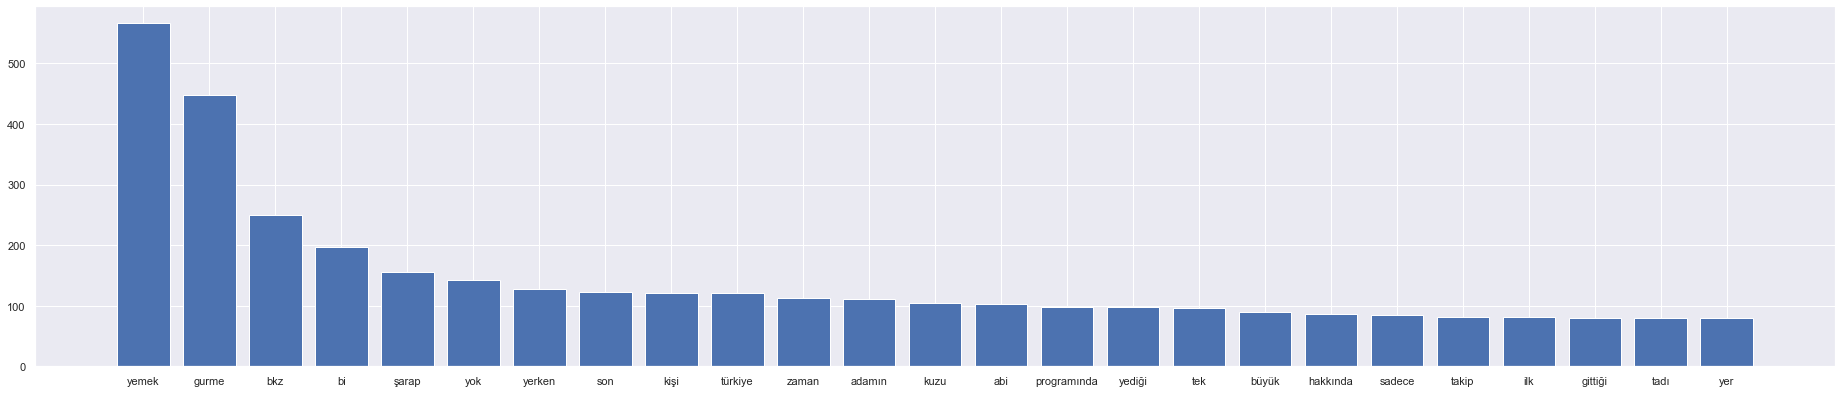

In [9]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = stop).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['text'], 25)
df2 = pd.DataFrame(common_words, columns = ['kelime' , 'geçiş frekansı'])
fig = plt.figure(figsize=[25,5])
ax = fig.add_axes([0,0,1,1])
ax.bar(df2.kelime,df2['geçiş frekansı'])
plt.show()


# Kelime Bulutları

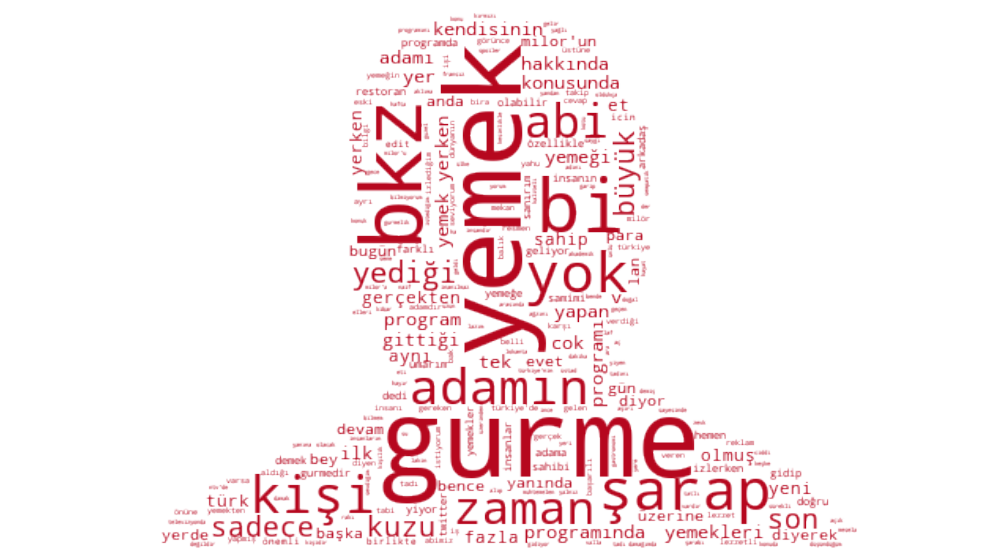

In [10]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl(352, 93%%, %d%%)" % 37

text = " ".join(review for review in data.text)

wine_mask = np.array(Image.open("vedat.jpg"))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=250, mask=wine_mask,
               stopwords=stop, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

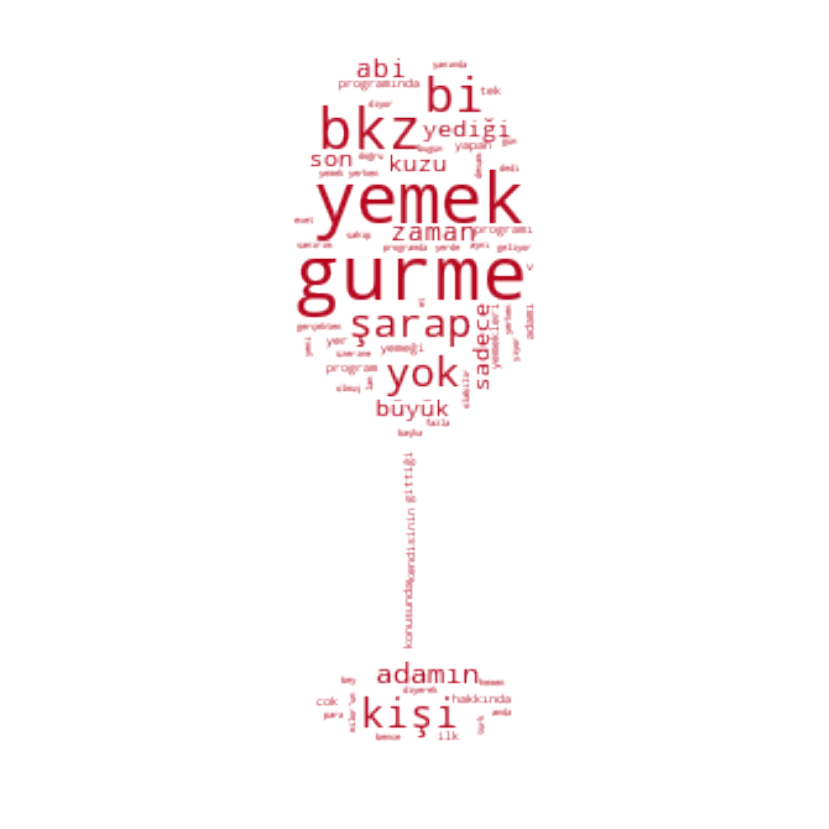

In [11]:
def red_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl(352, 93%%, %d%%)" % 37

text = " ".join(review for review in data.text)

wine_mask = np.array(Image.open("kadeh.jpg"))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=250, mask=wine_mask,
               stopwords=stop, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("kadeh.png")
# show
plt.figure(figsize=[25,15])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Duygu Bazlı Kelime Bulutları

## Pozitif

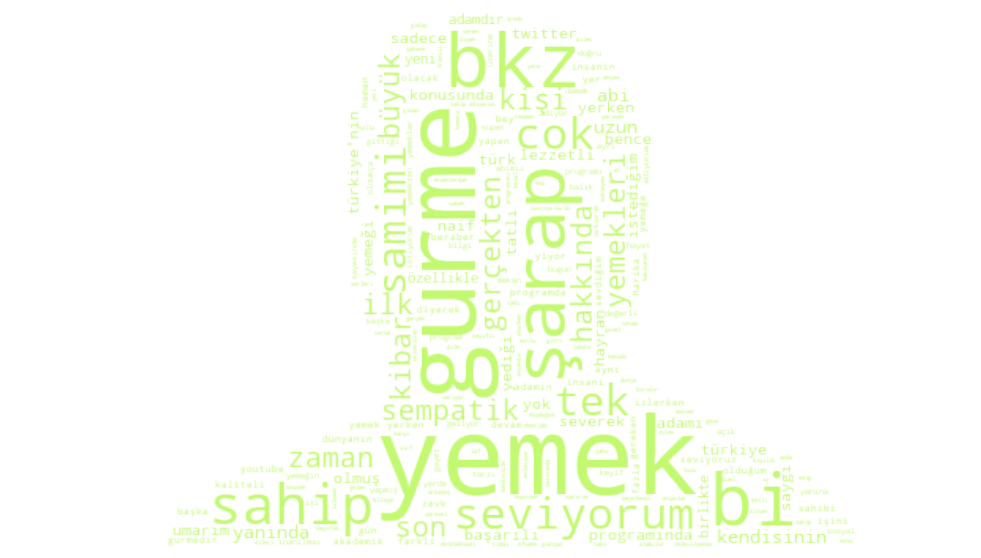

In [33]:
def color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl(84, 92%%, %d%%)" % 71

text = " ".join(review for review in data[data.sentiment=='Pozitif'].text)

wine_mask = np.array(Image.open("vedat.jpg"))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=250, mask=wine_mask,
               stopwords=stop, color_func=color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Negatif

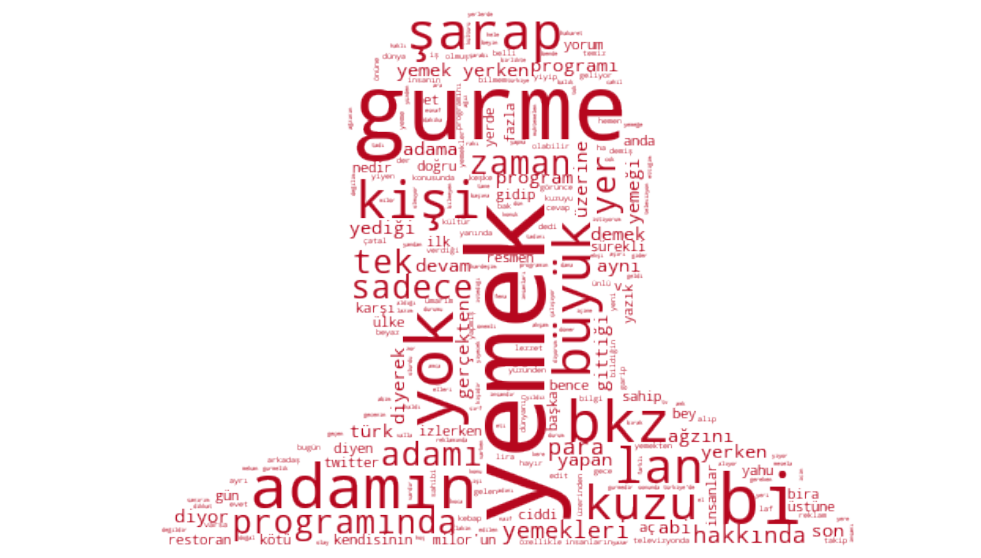

In [34]:
def color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl(84, 92%%, %d%%)" % 71

text = " ".join(review for review in data[data.sentiment=='Negatif'].text)

wine_mask = np.array(Image.open("vedat.jpg"))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=250, mask=wine_mask,
               stopwords=stop, color_func=red_color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Nötr

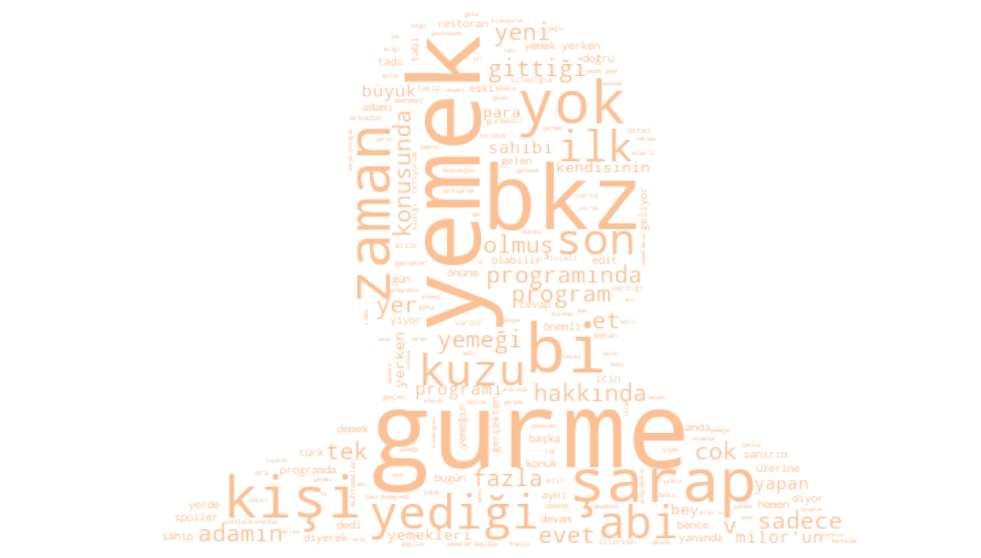

In [35]:
def color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return "hsl(26, 93%%, %d%%)" % 78

text = " ".join(review for review in data[data.sentiment=='Nötr'].text)

wine_mask = np.array(Image.open("vedat.jpg"))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=250, mask=wine_mask,
               stopwords=stop, color_func=color_func)

# Generate a wordcloud
wc.generate(text)
wc.to_file("vedat.png")
# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Zamana Bağlı Değişimler

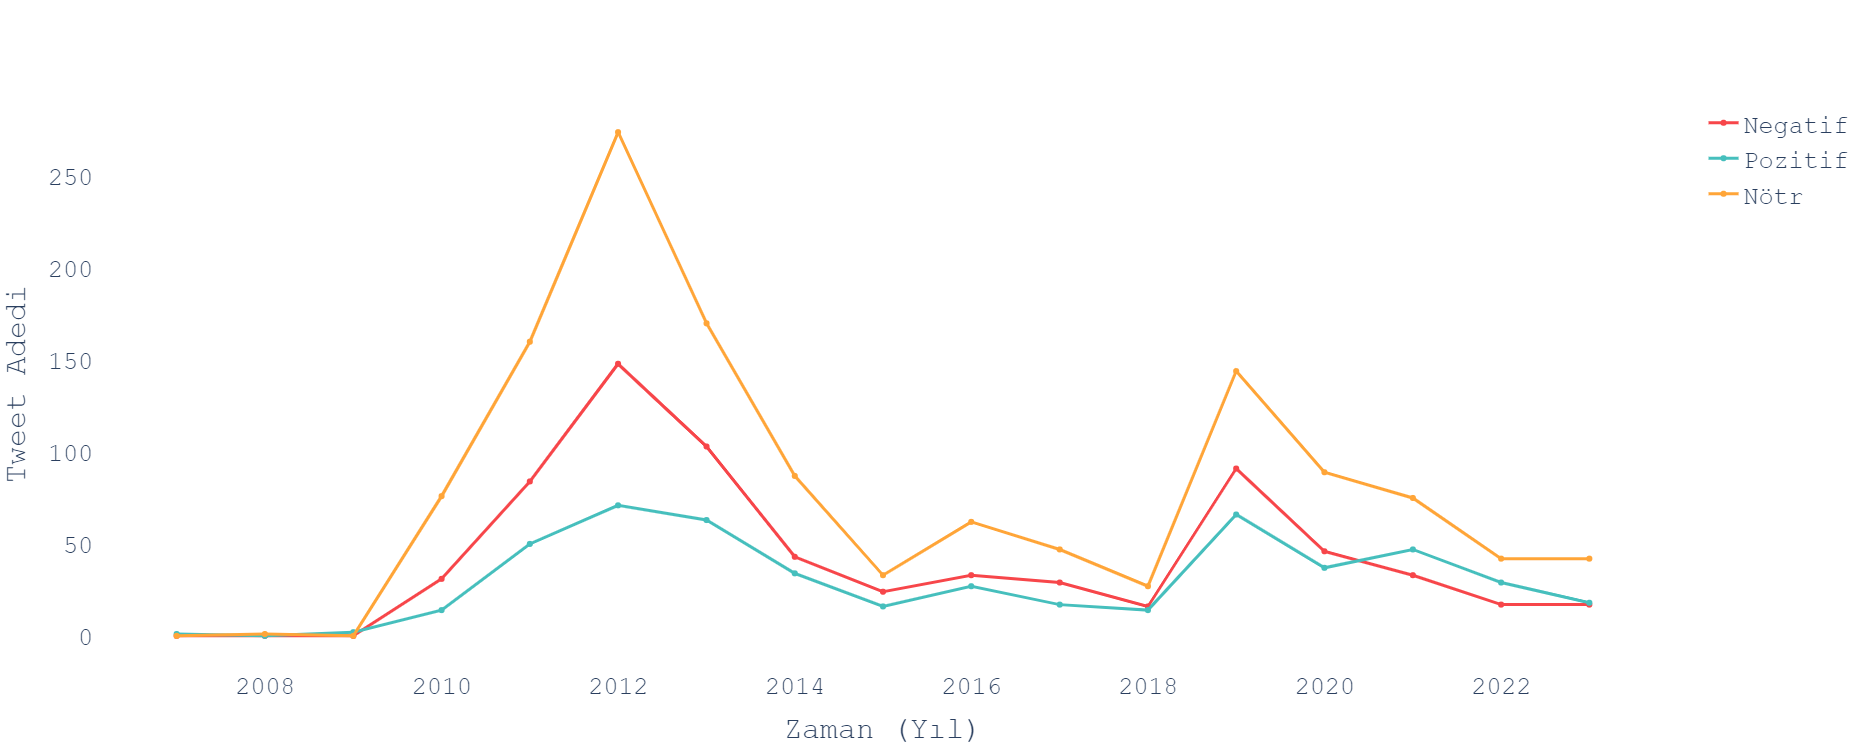

In [25]:
import plotly.graph_objects as go

data['date'] = pd.to_datetime(data.date)
line_chart_sentiment_data = data.set_index('date').groupby([pd.Grouper(freq='1Y'), 'sentiment']).count().unstack(fill_value=0).stack()['text'].reset_index()
line_chart_sentiment_data['date'] = line_chart_sentiment_data['date'].astype(str)

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=line_chart_sentiment_data[line_chart_sentiment_data.sentiment == 'Negatif'].date.values, y=line_chart_sentiment_data[line_chart_sentiment_data.sentiment == 'Negatif'].text.values,
                    mode='lines+markers',
                    line=dict(color='#F7464A', width=3),
                    name='Negatif',
                   ))

fig.add_trace(go.Scatter(x=line_chart_sentiment_data[line_chart_sentiment_data.sentiment == 'Pozitif'].date.values, y=line_chart_sentiment_data[line_chart_sentiment_data.sentiment == 'Pozitif'].text.values,
                    mode='lines+markers',
                    line=dict(color='#46BFBD', width=3),
                    name='Pozitif',
                   ))

fig.add_trace(go.Scatter(x=line_chart_sentiment_data[line_chart_sentiment_data.sentiment == 'Nötr'].date.values, y=line_chart_sentiment_data[line_chart_sentiment_data.sentiment == 'Nötr'].text.values,
                    mode='lines+markers',
                    line=dict(color='#FFA538', width=3),
                    name='Nötr',
                    ))

fig.update_layout(width=2000,
                  height=750,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis_title='Zaman (Yıl)',
                  yaxis_title='Tweet Adedi',
                 font=dict(
                    family="Courier New, monospace",
                    size=25
                    ))

fig.show()

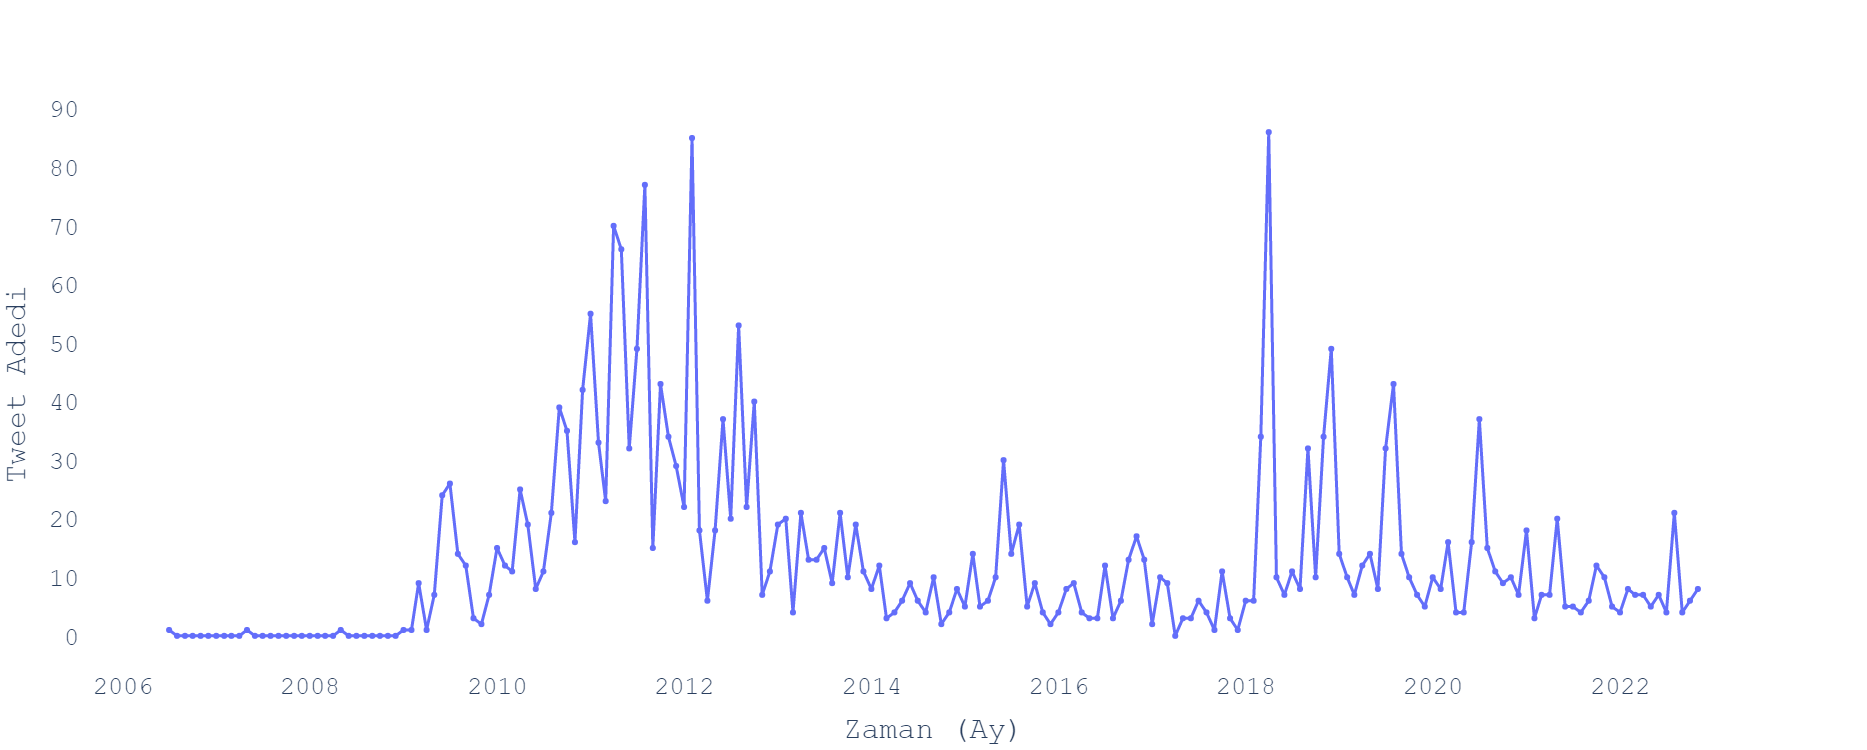

In [26]:
import plotly.graph_objects as go

data['date'] = pd.to_datetime(data.date)
line_chart_sentiment_data = data.set_index('date').groupby([pd.Grouper(freq='1M')]).count()['text'].reset_index()
line_chart_sentiment_data['date'] = line_chart_sentiment_data['date'].astype(str)

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=line_chart_sentiment_data.date.values, y=line_chart_sentiment_data.text.values,
                    mode='lines+markers',
                    line=dict(width=3),
                    name='Negatif',
                   ))

fig.update_layout(width=2000,
                  height=750,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis_title='Zaman (Ay)',
                  yaxis_title='Tweet Adedi',
                 font=dict(
                    family="Courier New, monospace",
                    size=25
                    ))

fig.show()

# En Sıkı Takipçiler

In [27]:
data.nickname.value_counts()

cagliari                                 15
bcm                                      13
seviyorsevmiyorseviyorsevmiyorseviyor    13
efendi                                   11
arnatuile                                10
                                         ..
kahraman tosba                            1
saltug                                    1
manowar yollarda yasar                    1
yoktan adam                               1
boudica                                   1
Name: nickname, Length: 1993, dtype: int64

In [31]:
data[data.nickname=='seviyorsevmiyorseviyorsevmiyorseviyor']

,text,date,nickname,date_year,sentiment,sentiment_score,stemmed
1420,galatasaray mezunu eski bir bakan'dan hayatını...,2014-01-25,seviyorsevmiyorseviyorsevmiyorseviyor,2014,Nötr,0.992737,galatasaray mezun esk bir bakan'dan hayat il...
1496,adamın en sevdiği lokanta kazasker 'deki konya...,2015-01-09,seviyorsevmiyorseviyorsevmiyorseviyor,2015,Nötr,0.932325,adam en sevdik lokan kazasker 'deki konya et...
1586,yarım saattir ekmekçide. baydı yani uzattı.,2015-08-22,seviyorsevmiyorseviyorsevmiyorseviyor,2015,Nötr,0.998485,yar saattir ekmekçide. bayt yan uzattı.
1754,eski modern türkiye’ nin son temsilcilerinden.,2017-12-15,seviyorsevmiyorseviyorsevmiyorseviyor,2017,Nötr,0.998631,esk modern türkiye’ nin son temsilcilerinden.
1765,gurme olduğunu iddia etmeyen kişidir. ben “gur...,2018-02-05,seviyorsevmiyorseviyorsevmiyorseviyor,2018,Nötr,0.962400,gurme olduk iddia etmeyen kişidir. ben “gurm...
1878,adamın avukatı değilim ama “yemek programlarin...,2018-03-16,seviyorsevmiyorseviyorsevmiyorseviyor,2018,Negatif,0.999512,adam avuk değil am “yemek programlarinda bir...
1889,arhavi'deymiş.,2018-04-27,seviyorsevmiyorseviyorsevmiyorseviyor,2018,Nötr,0.999126,arhavi'deymiş.
2065,yaban tavşanı yahnisi ‘ne laf edenleri bloklay...,2019-01-22,seviyorsevmiyorseviyorsevmiyorseviyor,2019,Nötr,0.998274,yaban tavşan yahni ‘ne laf eden bloklayacak ...
2076,kafası hafif kıyakken yaptığı yorumları daha ç...,2019-03-08,seviyorsevmiyorseviyorsevmiyorseviyor,2019,Pozitif,0.996793,kafa hafif kıyakken yaptık yorum dah çok beğ...
2078,yerine kızı ceylan ‘ı yetiştirdiğini düşündüğü...,2019-03-12,seviyorsevmiyorseviyorsevmiyorseviyor,2019,Nötr,0.790376,yer kız ceylan ‘ı yetiştirdik düşündük mill ...


# Referanslar
1. [Python ile Veri Kazıma(Web Scraping) Çalışması: Dünya Halleri Verisinin Kazınıp, Analiz Edilmesi ve Modellenmesi](https://medium.com/kaveai/web-scraping-453e96a86195)